# Predicting Grandmasters
## Volume 3 Math 402 Final Project

### Damian and Whitney Anderson,
### Nathan Christiansen, Reagan Howell

#### Date 11/16/2021

# Introduction
Have you ever started playing a game of chess online and wondered if your opponent was one of the top players on lichess.org?
In case you too have stumbled upon this all-too-common quandary, fear not. Have we got the predictor for you.
Grandmasters are expert players who consistently score high in international competitions. Frequently, highly advanced chess players will play online matches under pseudonyms, perhaps to attempt new approaches or shoot the breeze, as the kids say.
Chess, at its most elite, is not just a game of strategy but is also played with great personal style. Different players favor different techniques, to the point of their signatures being recognizable in their first few moves. Knowing who you are playing against can be game-turning information, as you’d better be able to anticipate their opening strategies.
We hypothesize that we could make a predictor effective enough to pinpoint who is playing in both classical (\~45 minute) and rapid (\~15 minute) format games by training classifiers using data from the top 27 players on lichess.org.

### Importing, Parsing and Cleaning the Data

All games were downloaded from lichess.org open database using links like this

https://lichess.org/api/games/user/Al_shima?rated=true&analysed=true&tags=true&clocks=true&evals=false&opening=false&perfType=rapid

The using regex to remove any of the unimportant information and stripping the .txt files to get the chess game Portable Game Notation (pgn) and the moves that were made.

In [1]:
import os, regex as re, numpy as np, pandas as pd
from sklearn.linear_model import LinearRegression, LogisticRegression,LogisticRegressionCV,Perceptron
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.naive_bayes import MultinomialNB,GaussianNB
from sklearn.neural_network import MLPClassifier
from statistics import mode
from parsing import *
from matplotlib import pyplot as plt
from statistics import mode
from matplotlib.colors import LogNorm

The main function utilizes the create_database() function to access the data files and build our DataFrame. We create a
DataFrame with columns for the players' name, color they were playing as, the variant, and the first 14 moves they make
in their game. We then import that Dataframe into chess_games.csv.


### Creating the X-data and the y-targets

Here we load chess_games.csv and break it into the data and the targets. We hope to predict the name of the Grandmaster
playing the game, so we choose the name column as our targets. We are using the first 14 moves the player makes in order
to predict who is playing, so our data is the 14 columns of moves from each game. We create a train/test split of .75
training and .25 testing.

## Naive Approach
If we just guessed the player with the most games, Rochade_Augsburg, our model would be right 40.73% of the time. So any model that we make should be able to beat this average. 
We started by just taking our train_test_split data and throwing it into all the reasonable machine learning models without any conditions on it. As a baseline measurement we took the mode of the all the players and divided it by the total number of games. 
Running a K-Nearest Neighbors, Multinomial Naive Bayes, a Random Forest, and a MultiLayer Perceptron Classifier, these are their results.

In [2]:
def load_():
    df = pd.read_csv("chess_games.csv")
    targets = df.Name
    data = df.drop(columns=['Name', 'Color', 'Variant', 'Moves'])
    return data, targets


def sets_():
    data, targets = load_()
    data = pd.get_dummies(data,columns=data.columns)
    xtrain,xtest,ytrain,ytest = train_test_split(data,targets)
    return xtrain,xtest,ytrain,ytest

xtrain,xtest,ytrain,ytest = sets_()

In [3]:
def generate_baseline(ytrain,ytest):
    best_guess = mode(ytrain)
    baseline = sum(ytest == best_guess) / len(ytest)
    return baseline, best_guess
print("Our baseline is {} which we get by guessing {}.".format(*generate_baseline(ytrain,ytest)))

Our baseline is 0.3940917661847894 which we get by guessing Rochade_Augsburg.


Now that we have split the data, we use several classifiers with some adjustments to hyper-parameters to figure out
which combination gives us the most accurate prediction of the Grandmaster playing any given game. In order to make
sure that no classifier got a better split than the others, we (begrudgingly) made the xtrain, xtest, ytrain, and ytest 
variables global and accessible to any function or method.


### Initial Model Training

After doing a lot of Grid Searching by "hand", we found the best hyperparamters, and we used those in our initial trainings.

In [4]:
print(f"When running a K Nearest Neighbors Classifier, we scored: {np.round(KNeighborsClassifier(n_neighbors=4,weights='distance',algorithm='brute').fit(xtrain,ytrain).score(xtest,ytest),4)}")
print(f"When running a Multinomial Naive Bayes Classifier, we scored: {np.round(MultinomialNB().fit(xtrain,ytrain).score(xtest,ytest),4)}")
print(f"When running a Random Forest  Classifier, we scored: {np.round(RandomForestClassifier().fit(xtrain,ytrain).score(xtest,ytest),4)}")
print(f"When running a Multi-Layer Perceptron , we scored: {np.round(MLPClassifier(hidden_layer_sizes=(50,)).fit(xtrain,ytrain).score(xtest,ytest),4)}")

When running a K Nearest Neighbors Classifier, we scored: 0.6361
When running a Multinomial Naive Bayes Classifier, we scored: 0.6078
When running a Random Forest  Classifier, we scored: 0.621
When running a Multi-Layer Perceptron , we scored: 0.6254


## Looking at Move Order
Our first attempt at refining our classifier was through editing our ‘Moves’ column. Since each game was recorded
as a white move/black move pair and just had another variable that tracked whether or not the player we were anlayzing was playing as white or black, we weren’t actually classifying the players based on their individual moves. Rather, we were classifying them as action-reaction pairs that showed up in their games. To resolve this, we used regular expressions to shift the moves in all games where the player was playing as black. By removing their white opponents’ first move, we were now looking at pairs where it was (player’s move, opponents reaction) in each.

In [5]:
#New data cleaning fucntions
def create_database():
    """
    Calls the files, get_games functions to creates a dataframe
    Returns a dataframe

    """
    file, players = files()
    df = []
    for i in range(len(players)):
        #create a list of all the files and their corresponding players and then input that list into the DataFrame
        df.extend(get_games(path + '/' + file[i], players[i]))
    df = pd.DataFrame(df, columns=['Name', 'Color', 'Variant', 'Moves'])
    df = df[df['Variant'] == 'Standard']
    
    # shift moves
    pattern = re.compile(r"( [0-9]+.)( \S+)")
    for i,m in enumerate(df.Moves):
        if df.iloc[i].Color=='Black':
            new = pattern.sub(r"\2\1",' '+m)
            df.iloc[i].Moves = new[new.find('1'):]
    
    return df
def load_():
    df = pd.read_csv("chess_games.csv")
    targets = df.Name
    data = df.drop(columns=['Name', 'Color', 'Variant', 'Moves'])
    return data, targets


def sets_():
    data, targets = load_()
    data = pd.get_dummies(data,columns=data.columns)
    xtrain,xtest,ytrain,ytest = train_test_split(data,targets)
    # params = {'n_neighbors': [2,3,4],
    #         'weights' :['uniform','distance'],
    #         'leaf_size' : [30,40,50,60],
    #
    # }
    return xtrain,xtest,ytrain,ytest

xtrain,xtest,ytrain,ytest = sets_()


In [6]:
print(f"When looking at the Move order and running a K Nearest Neighbors Classifier, we scored: {np.round(KNeighborsClassifier(n_neighbors=4,weights='distance',algorithm='brute').fit(xtrain,ytrain).score(xtest,ytest),4)}")
print(f"When looking at the Move order and running a Multinomial Naive Bayes Classifier, we scored: {np.round(MultinomialNB().fit(xtrain,ytrain).score(xtest,ytest),4)}")
print(f"When looking at the Move order and running a Random Forest Classifier, we scored: {np.round(RandomForestClassifier().fit(xtrain,ytrain).score(xtest,ytest),4)}")
print(f"When looking at the Move order and running a Multi Layer Perceptron, we scored: {np.round(MLPClassifier(hidden_layer_sizes=(50,)).fit(xtrain,ytrain).score(xtest,ytest),4)}")
print(f"When looking at the Move order and running a Naive Bayes Classifier, we scored: {np.round(GaussianNB().fit(xtrain,ytrain).score(xtest,ytest),4)}")

When looking at the Move order and running a K Nearest Neighbors Classifier, we scored: 0.6392
When looking at the Move order and running a Multinomial Naive Bayes Classifier, we scored: 0.6047
When looking at the Move order and running a Random Forest Classifier, we scored: 0.6084
When looking at the Move order and running a Multi Layer Perceptron, we scored: 0.6053
When looking at the Move order and running a Naive Bayes Classifier, we scored: 0.5525


## Splitting on color
Each of the classifiers gives us about a 60-65% confidence rate in predicting the Grandmaster that we are playing against in any given game. Given that this is from a set of 27 Grandmasters, that means that just a random guess would be correct about 3-4 percent of the time, we feel that this is a pretty good algorithm for prediction.
Next, we will adjust the way that we organize our data. We know that in a game of chess, whether you are playing as white or black vastly changes the sort of strategy that one employs, white being more offensive and black being more defensive. So we will split the data into two databases, separating them based on whether they are playing as black or as white. This may give us a better prediction model as well.
Again, we will try several different classifiers to score our prediction models.

In [7]:
#Getting the White and black data sets
def load_():
    df = pd.read_csv("chess_games.csv")
    targets = df.Name
    data = df.drop(columns=['Name', 'Variant', 'Moves'])
    return data, targets


def sets_():
    data, targets = load_()
    cols = list(data.columns).remove("Color")
    data = pd.get_dummies(data,columns=cols)
    xtrain0,xtest0,ytrain0,ytest0 = train_test_split(data[data['Color_White']==0],targets[data['Color_White']==0])
    xtrain1,xtest1,ytrain1,ytest1 = train_test_split(data[data['Color_White']==1],targets[data['Color_White']==1])

    xtrain0.drop(columns=['Color_White','Color_Black'],inplace=True)
    xtest0.drop(columns=['Color_White','Color_Black'],inplace=True)
    xtrain1.drop(columns=['Color_White','Color_Black'],inplace=True)
    xtest1.drop(columns=['Color_White','Color_Black'],inplace=True)

    return xtrain0,xtest0,ytrain0,ytest0,xtrain1,xtest1,ytrain1,ytest1

xtrain0,xtest0,ytrain0,ytest0,xtrain1,xtest1,ytrain1,ytest1 = sets_()


Testing on the color split

In [8]:
print(f'Testing K Nearest Neighbors Classifier on the Black games and scored : {KNeighborsClassifier(n_neighbors=4,weights="distance",algorithm="brute").fit(xtrain0,ytrain0).score(xtest0,ytest0)}')
print(f'Testing K Nearest Neighbors Classifier on the White games and scored : {KNeighborsClassifier(n_neighbors=4,weights="distance",algorithm="brute").fit(xtrain1,ytrain1).score(xtest1,ytest1)}')
print(f'Testing Multinomial Naive Bayes Classifier on the Black games and scored : {MultinomialNB().fit(xtrain0,ytrain0).score(xtest0,ytest0)}')
print(f'Testing Multinomial Naive Bayes Classifier on the White games and scored : {MultinomialNB().fit(xtrain1,ytrain1).score(xtest1,ytest1)}')
print(f'Testing Random Forest Classifier on the Black games and scored : {RandomForestClassifier().fit(xtrain0,ytrain0).score(xtest0,ytest0)}')
print(f'Testing Random Forest Classifier on the White games and scored : {RandomForestClassifier().fit(xtrain1,ytrain1).score(xtest1,ytest1)}')
print(f'Testing Multi Layer Perceptron on the Black games and scored : {MLPClassifier().fit(xtrain0,ytrain0).score(xtest0,ytest0)}')
print(f'Testing Multi Layer Perceptron on the White games and scored : {MLPClassifier().fit(xtrain1,ytrain1).score(xtest1,ytest1)}')
print(f'Testing Naive Bayes Classifier on the Black games and scored : {GaussianNB().fit(xtrain0,ytrain0).score(xtest0,ytest0)}')
print(f'Testing Naive Bayes Classifier on the White games and scored : {GaussianNB().fit(xtrain1,ytrain1).score(xtest1,ytest1)}')

Testing K Nearest Neighbors Classifier on the Black games and scored : 0.9954545454545455
Testing K Nearest Neighbors Classifier on the White games and scored : 0.9913194444444444
Testing Multinomial Naive Bayes Classifier on the Black games and scored : 0.5181818181818182
Testing Multinomial Naive Bayes Classifier on the White games and scored : 0.3776041666666667
Testing Random Forest Classifier on the Black games and scored : 0.7727272727272727
Testing Random Forest Classifier on the White games and scored : 0.7534722222222222
Testing Multi Layer Perceptron on the Black games and scored : 0.7090909090909091
Testing Multi Layer Perceptron on the White games and scored : 0.6944444444444444
Testing Naive Bayes Classifier on the Black games and scored : 0.23636363636363636
Testing Naive Bayes Classifier on the White games and scored : 0.4322916666666667


###### Why is the K Nearest Neighbors classifier working so well compared to the other classifiers?
K Nearest Neighbors works by looking at the given row of data, and finding the K rows of data that are most similar to the given row. The label that is most common in those K “Nearest Neighbors” is the label that is chosen to classify the given row of data. In our data, this corresponds to looking at the first 15 moves of the given game, and finding games where the first 15 moves were very similar. As with any sort of game involving strategy, people who play the game will find their style of play and regularly fall back on the same moves that are often successful for them. So given a game played by a certain Grandmaster, the games with the most similar moves will be played by themselves, and thus the K Nearest Neighbors classifier was able to recognize the person who played the game.


In [9]:
def sets_():
    data, targets = load_()
    # print(data.columns)
    cols = list(data.columns).remove("Color")
    data = pd.get_dummies(data,columns=cols)
    # print(data.columns)
    # print(data[data['Color_White']==1])
    xtrain,xtest,ytrain,ytest = train_test_split(data[data['Color_White']==0],targets[data['Color_White']==0])
    xtrain.drop(columns=['Color_White','Color_Black'],inplace=True)
    xtest.drop(columns=['Color_White','Color_Black'],inplace=True)

    return xtrain,xtest,ytrain,ytest

b_xtrain,b_xtest,b_ytrain,b_ytest = sets_()
#black
black_predict = KNeighborsClassifier(n_neighbors=4,weights='uniform',algorithm='brute').fit(b_xtrain,b_ytrain).predict(b_xtest)
black_score = sum(black_predict == b_ytest) / len(b_ytest)
def sets_():
    data, targets = load_()
    # print(data.columns)
    cols = list(data.columns).remove("Color")
    data = pd.get_dummies(data,columns=cols)
    # print(data.columns)
    # print(data[data['Color_White']==1])
    xtrain,xtest,ytrain,ytest = train_test_split(data[data['Color_White']==1],targets[data['Color_White']==1])
    xtrain.drop(columns=['Color_White','Color_Black'],inplace=True)
    xtest.drop(columns=['Color_White','Color_Black'],inplace=True)

    return xtrain,xtest,ytrain,ytest

w_xtrain,w_xtest,w_ytrain,w_ytest = sets_()
#white
white_predict = KNeighborsClassifier(n_neighbors=4,weights='uniform',algorithm='brute').fit(w_xtrain,w_ytrain).predict(w_xtest)
white_score = sum(white_predict == w_ytest) / len(w_ytest)

In [10]:
def confusion_matrix(actual, guesses):
    actual = np.array(actual)
    guesses = np.array(guesses)
    outputs = np.unique(np.concatenate((actual, guesses)))
    output_to_index = dict()
    for i in range(len(outputs)):
        output_to_index[outputs[i]] = i

    matrix = np.zeros((len(outputs), len(outputs)))

    for i in range(len(actual)):
        matrix[output_to_index[actual[i]], output_to_index[guesses[i]]] += 1
    return outputs, matrix

In [11]:
def summarize_confusion(outputs, matrix):
    for i in range(len(outputs)):
        print(str(outputs[i]) + ":")
        print("Correctly identified " + str(int(matrix[i][i])) + " games out of " + str(int(sum(matrix[i]))) + ".")
        for j in range(len(outputs)):
            if i == j:
                continue
            if matrix[i][j] == 1:
                print(str(int(matrix[i][j])) + " game was misclassified as " + str(outputs[j]) + ".")
            if matrix[i][j] > 1:
                print(str(int(matrix[i][j])) + " games were misclassified as " + str(outputs[j]) + ".")
        print()

In [12]:
black_labels, black_matrix = confusion_matrix(b_ytest, black_predict)
white_labels, white_matrix = confusion_matrix(w_ytest, white_predict)
labels, matrix = confusion_matrix(np.concatenate((w_ytest, b_ytest)), np.concatenate((white_predict, black_predict)))

In [13]:
summarize_confusion(labels, matrix)

ARM__55555:
Correctly identified 14 games out of 16.
2 games were misclassified as Casabianka.

Casabianka:
Correctly identified 56 games out of 56.

GabrielTricks2003:
Correctly identified 38 games out of 38.

GrandLapin:
Correctly identified 53 games out of 54.
1 game was misclassified as GabrielTricks2003.

HoochieChoochieMan:
Correctly identified 28 games out of 29.
1 game was misclassified as GrandLapin.

IAmMateCheckMate:
Correctly identified 62 games out of 62.

Jack202013:
Correctly identified 31 games out of 31.

Jebatdurhaka:
Correctly identified 49 games out of 49.

Konnov_Oleg:
Correctly identified 20 games out of 23.
1 game was misclassified as Leleilre.
2 games were misclassified as kc6.

Leleilre:
Correctly identified 18 games out of 18.

Lord-Universe31:
Correctly identified 52 games out of 54.
2 games were misclassified as Leleilre.

Medarde94:
Correctly identified 9 games out of 9.

Rochade_Augsburg:
Correctly identified 620 games out of 620.

RusChessCoach:
Correctly

## Confusion Matrix

The confusion matrix shows which players are misclassified as which other players.
The row corresponds to the actual player and the column corresponds to the predicted player.
Above each confusion matrix is a list of all the players in the matrix, ordered left to right or top to bottom Dark.
These confusion matrices are generated using k nearest neighbors with 4 neighbors.
100% accuracy corresponds to all the colors being on the main diagonal

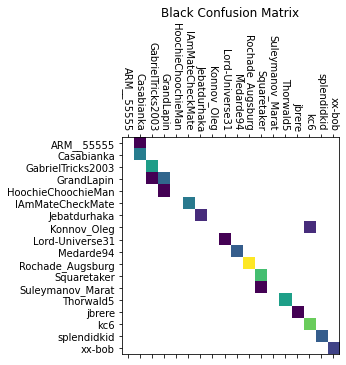

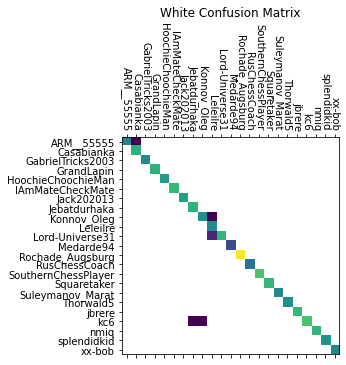

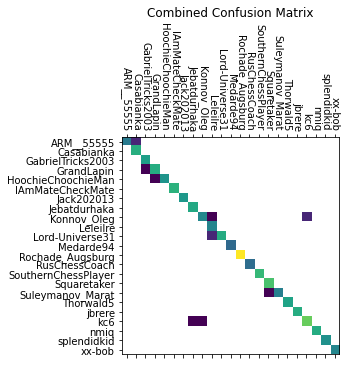

In [14]:
plt.figure()
plt.dpi = 100
ax1 = plt.subplot(111)
plt.title("Black Confusion Matrix")
ax1.matshow(black_matrix, norm = LogNorm())
ax1.set_xticks(range(len(black_labels)))
ax1.set_xticklabels(black_labels)
ax1.tick_params(axis="x", rotation=-90)
ax1.set_yticks(range(len(black_labels)))
ax1.set_yticklabels(black_labels)
# plt.colorbar(c, ax = ax1)
plt.show()

plt.figure()
ax2 = plt.subplot(111)
plt.title("White Confusion Matrix")
ax2.matshow(white_matrix, norm = LogNorm())
ax2.set_xticks(range(len(white_labels)))
ax2.set_xticklabels(white_labels)
ax2.tick_params(axis="x", rotation=-90)
ax2.set_yticks(range(len(white_labels)))
ax2.set_yticklabels(white_labels)
# plt.colorbar(c, ax = ax2)
plt.show()

plt.figure()
ax3 = plt.subplot(111)
plt.title("Combined Confusion Matrix")
ax3.matshow(matrix, norm = LogNorm())
ax3.set_xticks(range(len(labels)))
ax3.set_xticklabels(labels)
ax3.tick_params(axis="x", rotation=-90)
ax3.set_yticks(range(len(labels)))
ax3.set_yticklabels(labels)
# plt.colorbar(c, ax = ax3)
plt.show()

In [15]:
score = (white_score * len(w_ytest) + black_score * len(b_ytest)) / (len(b_ytest) + len(w_ytest))
print("White classification", white_score)
print("Black classification", black_score)
print("Average score", score)

White classification 0.9947916666666666
Black classification 0.9863636363636363
Average score 0.992462311557789


## Removing a Player

As data scientists, we have learned to not really trust data. Therefore, we are astounded and amazed at the accuracy of our predicter. We do recognize that over half of our data is games played by one player, Rochade_Augsburg, which could be skewing the accuracy of the predicter by having such a common name to guess. In an attempt to gut check our predicter, we have built a new database with all of Rochade_Augsburg's data removed, so that we can confirm that our predictor is accurate.

In [18]:
def load_():
    df = pd.read_csv("chess_games.csv")
    targets = df.Name
    df,targets = df[df["Name"]!="Rochade_Augsburg"],targets[df["Name"]!="Rochade_Augsburg"]
    data = df.drop(columns=['Name', 'Variant', 'Moves'])
    
    return data, targets


def sets_():
    df = pd.read_csv("chess_games.csv")
    targets = df.Name
    df,targets = df[df["Name"]!="Rochade_Augsburg"],targets[df["Name"]!="Rochade_Augsburg"]
    data = df.drop(columns=['Name', 'Variant', 'Moves'])
#     print(data['Unnamed: 0'])
#     print(len(data[data['Unnamed: 0']!="Rochade_Augsburg"]))
#     data,targets = data[data["Name"]!="Rochade_Augsburg"],targets[data["Name"]!="Rochade_Augsburg"]
#     cols = list(data.columns).remove("Color")
    data = pd.get_dummies(data,columns=data.columns)

    xtrain0,xtest0,ytrain0,ytest0 = train_test_split(data[data['Color_White']==0],targets[data['Color_White']==0])
    xtrain1,xtest1,ytrain1,ytest1 = train_test_split(data[data['Color_White']==1],targets[data['Color_White']==1])

    xtrain0.drop(columns=['Color_White','Color_Black'],inplace=True)
    xtest0.drop(columns=['Color_White','Color_Black'],inplace=True)
    xtrain1.drop(columns=['Color_White','Color_Black'],inplace=True)
    xtest1.drop(columns=['Color_White','Color_Black'],inplace=True)

    return xtrain0,xtest0,ytrain0,ytest0,xtrain1,xtest1,ytrain1,ytest1

xtrain0,xtest0,ytrain0,ytest0,xtrain1,xtest1,ytrain1,ytest1 = sets_()

In [24]:
def sets_():
    df = pd.read_csv("chess_games.csv")
    targets = df.Name
    df,targets = df[df["Name"]!="Rochade_Augsburg"],targets[df["Name"]!="Rochade_Augsburg"]
    data = df.drop(columns=['Name', 'Variant', 'Moves'])

    # data,targets = data[data["Name"]!="Rochade_Augsburg"],targets[data["Name"]!="Rochade_Augsburg"]
    # print(data.columns)
    cols = list(data.columns).remove("Color")
    data = pd.get_dummies(data,columns=cols)

    # print(data.columns)
    # print(data[data['Color_White']==1])
    xtrain,xtest,ytrain,ytest = train_test_split(data[data['Color_White']==0],targets[data['Color_White']==0])
    xtrain.drop(columns=['Color_White','Color_Black'],inplace=True)
    xtest.drop(columns=['Color_White','Color_Black'],inplace=True)

    return xtrain,xtest,ytrain,ytest

b_xtrain,b_xtest,b_ytrain,b_ytest = sets_()
#black
black_predict = KNeighborsClassifier(n_neighbors=4,weights='uniform',algorithm='brute').fit(b_xtrain,b_ytrain).predict(b_xtest)
black_score = sum(black_predict == b_ytest) / len(b_ytest)
def sets_():
    df = pd.read_csv("chess_games.csv")
    targets = df.Name
    df,targets = df[df["Name"]!="Rochade_Augsburg"],targets[df["Name"]!="Rochade_Augsburg"]
    data = df.drop(columns=['Name', 'Variant', 'Moves'])
    # data,targets = data[data["Name"]!="Rochade_Augsburg"],targets[data["Name"]!="Rochade_Augsburg"]

    # print(data.columns)
    cols = list(data.columns).remove("Color")
    data = pd.get_dummies(data,columns=cols)
    # print(data.columns)
    # print(data[data['Color_White']==1])
    xtrain,xtest,ytrain,ytest = train_test_split(data[data['Color_White']==1],targets[data['Color_White']==1])
    xtrain.drop(columns=['Color_White','Color_Black'],inplace=True)
    xtest.drop(columns=['Color_White','Color_Black'],inplace=True)

    return xtrain,xtest,ytrain,ytest

w_xtrain,w_xtest,w_ytrain,w_ytest = sets_()
#white
white_predict = KNeighborsClassifier(n_neighbors=4,weights='uniform',algorithm='brute').fit(w_xtrain,w_ytrain).predict(w_xtest)
white_score = sum(white_predict == w_ytest) / len(w_ytest)

In [25]:
print("Our new white baseline is {} which we get by guessing {}.".format(*generate_baseline(ytrain1,ytest1)))

Our new white baseline is 0.08748317631224764 which we get by guessing kc6.


In [26]:
print("Our new black baseline is {} which we get by guessing {}.".format(*generate_baseline(ytrain0,ytest0)))

Our new black baseline is 0.3463414634146341 which we get by guessing kc6.


In [27]:
print(f'Testing K Nearest Neighbors Classifier on the Black games and scored : {KNeighborsClassifier(n_neighbors=4,weights="distance",algorithm="brute").fit(xtrain0,ytrain0).score(xtest0,ytest0)}')
print(f'Testing K Nearest Neighbors Classifier on the White games and scored : {KNeighborsClassifier(n_neighbors=4,weights="distance",algorithm="brute").fit(xtrain1,ytrain1).score(xtest1,ytest1)}')
# print(f'Testing Multinomial Naive Bayes Classifier on the Black games and scored : {MultinomialNB().fit(xtrain0,ytrain0).score(xtest0,ytest0)}')
# print(f'Testing Multinomial Naive Bayes Classifier on the White games and scored : {MultinomialNB().fit(xtrain1,ytrain1).score(xtest1,ytest1)}')
# print(f'Testing Random Forest Classifier on the Black games and scored : {RandomForestClassifier().fit(xtrain0,ytrain0).score(xtest0,ytest0)}')
# print(f'Testing Random Forest Classifier on the White games and scored : {RandomForestClassifier().fit(xtrain1,ytrain1).score(xtest1,ytest1)}')
# print(f'Testing Multi Layer Perceptron on the Black games and scored : {MLPClassifier().fit(xtrain0,ytrain0).score(xtest0,ytest0)}')
# print(f'Testing Multi Layer Perceptron on the White games and scored : {MLPClassifier().fit(xtrain1,ytrain1).score(xtest1,ytest1)}')
# print(f'Testing Naive Bayes Classifier on the Black games and scored : {GaussianNB().fit(xtrain0,ytrain0).score(xtest0,ytest0)}')
# print(f'Testing Naive Bayes Classifier on the White games and scored : {GaussianNB().fit(xtrain1,ytrain1).score(xtest1,ytest1)}')

Testing K Nearest Neighbors Classifier on the Black games and scored : 0.624390243902439
Testing K Nearest Neighbors Classifier on the White games and scored : 0.46837146702557203


After removing Rochade_Augsburg’s data, notice that the next most common player is kc6, who makes up a much smaller portion of the dataset than Rochade_Augsburg did before.
We also note that each classifier performed nearly as well on this stripped dataset, showing that we are still able to produce fantastic results with a more equally weighted dataset.


## Ethics

As all of the data can be obtained from Lichess, we did not use any data that was not already publicly available.
Lichess players expect their games to be saved so they are aware their game data could be observed.
Since these players are higher rated, they likely know that their lichess data could be used for purposes like this.

## Moving Forward

Since we have achieved great success at predicting the chess player based off of the game, we could try to do the same for chess 960, a variant of chess created by Bobby Fisher with randomized starting positions.
We believe that the variety of starting positions would make KNN perform less well since it is less likely that we will find a similar game from the same player when the starting position that led to the game only occurs once out of every 960 times.
We could test this and know for sure.